Comment

In [1]:
#get Reynolds stress by using timeaverage and then horizontal averaging
#¯u: time average
#<>u: horizontal average
#u' = u - ¯u
#u'' = u' - <u>
#-<¯u'w'>: averaged Reynolds shear stress
#-<¯u''w''>: dispersive shear stress

Firsly, we go into working directory file.
Secondly, we open the following file such as mean_field_3di.h5 or mean_tke_3d.h5 to get the data.
Thirdly, we use it to get the value we want
Lastly, we save it into the output file or visulize it.

The first term I think we got it in the budget part. So I think we dig this part deeper

In [2]:
#import neccesary library
import sys
import h5py
import numpy as np
import tecplot_io as tec
import os
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.ticker as tck

In [3]:
#change working directory
path = 'd:\post\Fixed_new'
path0 = 'd:\post\Fixed_new'
path1 = 'd:\post\Pitch_test'
path2 = 'd:\post\SWAY'
os.chdir(path)
print("current working directory is: {0}".format(os.getcwd()))

current working directory is: d:\post\Fixed_new


In [4]:
#parameters
#kappa = 0.4
#nu = 1.511e-5
#PEX = 1.45444104333
#PEY = 8.72664625997
#hbar = 0.46
#uinfty = 2.54390548295
dt = 0.68543297937
#Rotational angular period
T_turb = 42.84
U_star = 0.356
H_hub = 70
#Mean finite velocity
U = 11.5258407161
tis = 200
tie = 15000
tii = 200
nti = int((tie - tis) / tii + 1)

Calculate dispersive (or canopy) shear stress

In [5]:
def get_dispersive_shear_stress(path):
    os.chdir(path)
    print("current working directory is: {0}".format(os.getcwd()))
    #open nessesary file
    fname = 'mean_field_3d.h5'
    f = h5py.File(fname, "r")
    u = f["u"]
    v = f["v"]
    w2 = f["w"]
    w = np.array(w2).copy()
    #get mean velocity profile
    NPX = u.shape[2]
    NPY = u.shape[1]
    NPZ = u.shape[0]
    u_horizontal  = np.zeros((NPZ,3))
    u_hm = np.zeros((NPZ, NPY, NPX))
    v_hm = np.zeros((NPZ, NPY, NPX))
    w_hm = np.zeros((NPZ, NPY, NPX))
    u_prime_all = np.zeros((NPZ, NPY, NPX))
    v_prime_all = np.zeros((NPZ, NPY, NPX))
    w_prime_all = np.zeros((NPZ, NPY, NPX))


    w[0, :, :] = w2[0, :, :]
    for k in range(1,NPZ):
        w[k, :, :] = 0.5*(w2[k-1, :, :] + w2[k, :, :])
        u_horizontal[k, 0] = np.average(u[k,:,:])
        u_horizontal[k, 1] = np.average(v[k,:,:])
        u_horizontal[k, 2] = np.average(w[k,:,:])
    #redimensionalize array
    for i in range (NPX):
        for j in range (NPY):
            u_hm[:,j,i] = u_hm[:,j,i] + u_horizontal[:,0]
            v_hm[:,j,i] = v_hm[:,j,i] + u_horizontal[:,1]
            w_hm[:,j,i] = w_hm[:,j,i] + u_horizontal[:,2]
    #horizontal average mean velocity profile

    #get instantaneous velocity profile
    for it in range(nti):
        ti = tis + tii * it
        fname = 'DAT_{:010d}.h5'.format(ti)
    #    print("Reading file "+ fname)
        f1 = h5py.File(fname, "r")

        #print("Keys: %s" % f.keys())
        ## Old version Keys: [u'dz', u'dzw', u'eta', u'eta0', u'hh', u'pp', u'u', u'v', u'w', u'z', u'zw', u'zz']
        ## New version Keys: [u'eta', u'hh', u'pp', u'u', u'v', u'w', u'z']
        u_i = f1["u"]
        v_i = f1["v"]
        w2_i = f1["w"]
        w_i = np.array(w2_i).copy()

        w_i[0, :, :] = w2_i[0, :, :]
        for k in range(1,NPZ):
            w_i[k, :, :] = 0.5*(w2_i[k-1, :, :] + w2_i[k, :, :])
        u_prime = u_i - u_hm
        v_prime = v_i - v_hm
        w_prime = w_i - w_hm 

        u_prime_all = u_prime_all + u_prime
        v_prime_all = v_prime_all + v_prime
        w_prime_all = w_prime_all + w_prime
    
#time average
    u_prime_all = u_prime_all / nti
    v_prime_all = v_prime_all / nti
    w_prime_all = w_prime_all / nti

    #get dispersive shear stress
    dispersive_shear_stress = -(u_prime_all * w_prime_all)
    #dispersive_shear_stress_horizontal_average
    dispersive_shear_stress_horizontal_average = np.zeros((NPZ))
    for i in range(NPZ):
        dispersive_shear_stress_horizontal_average[i] = np.average(dispersive_shear_stress[i,:,:])
    return dispersive_shear_stress_horizontal_average
    

Reynolds shear stress relies on the mean_tke_3d.h5. We just open it and horizontal average it

In [6]:
def get_reynolds_shear_stress(path):
    os.chdir(path)
    print("Current directory: " + os.getcwd())
    fname = 'mean_tke_3d.h5'
    f2 = h5py.File(fname, "r")
    tke = f2["TKE"]
    Reynolds = f2["u'w'"]
    Reynolds_horizal_average = np.zeros((NPZ))
    for i in range(NPZ):
        Reynolds_horizal_average[i] = np.average(Reynolds[i,:,:])
    return Reynolds_horizal_average

get zz

In [7]:
def get_zz(path):
    os.chdir(path)
    print("Current directory: " + os.getcwd())
    fname = 'DAT_{:010d}.h5'.format(tis)
    f1 = h5py.File(fname, "r")
    zz = np.array(f1["z"][:,0,0]).copy()
    return zz
    

In [8]:
fname = 'mean_field_3d.h5'
f0 = h5py.File(fname, "r")
u = f0["u"]
NPX = u.shape[2]
NPY = u.shape[1]
NPZ = u.shape[0]

In [10]:
data = np.zeros((NPZ,7))
data[:,0] = get_zz(path0)/H_hub
data[:,1] = get_dispersive_shear_stress(path0)/(U_star**2)
#data[:,2] = get_reynolds_shear_stress(path0)/(U_star**2)
data[:,3] = get_dispersive_shear_stress(path1)/(U_star**2)
#data[:,4] = -get_reynolds_shear_stress(path1)/(U_star**2)
data[:,5] = get_dispersive_shear_stress(path2)/(U_star**2)
#data[:,6] = get_reynolds_shear_stress(path2)/(U_star**2)

Current directory: d:\post\Fixed_new
current working directory is: d:\post\Fixed_new
current working directory is: d:\post\Pitch_test
current working directory is: d:\post\SWAY


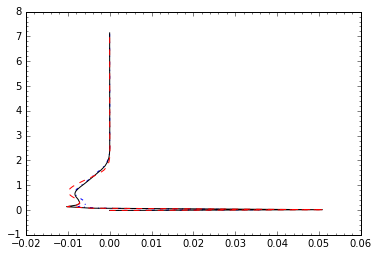

In [12]:
plt.style.use('classic')
%matplotlib inline
fig, ax = plt.subplots()
plt.plot(data[:,1], data[:,0], data[:,3], data[:,0], data[:,5], data[:,0])
plt.gca().get_lines()[1].set_color('black')
plt.gca().get_lines()[0].set_linestyle('-.')
plt.gca().get_lines()[2].set_linestyle('--')
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
plt.show()

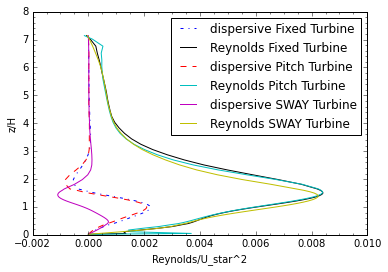

In [ ]:
plt.style.use('classic')
%matplotlib inline
fig, ax = plt.subplots()
plt.plot(data[:,1], data[:,0], data[:,2], data[:,0], data[:,3], \
         data[:,0], data[:,4], data[:,0], data[:,5], data[:,0], \
         data[:,6], data[:,0])
plt.gca().get_lines()[1].set_color('black')
plt.gca().get_lines()[0].set_linestyle('-.')
plt.gca().get_lines()[2].set_linestyle('--')
plt.xlabel('Reynolds/U_star^2')
plt.ylabel('z/H')
plt.legend(['dispersive Fixed Turbine', 'Reynolds Fixed Turbine',\
            'dispersive Pitch Turbine', 'Reynolds Pitch Turbine',\
            'dispersive SWAY Turbine', 'Reynolds SWAY Turbine'], \
            loc = 'upper right') 
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
plt.show()

Store data for tecplot format

In [ ]:
os.chdir('d:\post')
outputfolder = 'post_result/'
#create output folder named 'post_result' 
if not os.path.exists(outputfolder):
    os.makedirs(outputfolder)
f1 = open( outputfolder + "profile of shear stress.plt",'w')
f1.write("VARIABLES = z/H, dispersive Fixed Turbine, Reynolds Fixed Turbine,\
         dispersive Pitch Turbine, Reynolds Pitch Turbine,\
         dispersive SWAY Turbine, Reynolds SWAY Turbine  \n")
np.savetxt(f1, data)
f1.close()

In [ ]:
print('Done!')

Done!
